# MICROSOFT COMPUTER VISION API - DEMO

## Intro

Before running this notebook please:

1. Create a Cognitive Services resource using the Azure portal.

2. Configure the environment variables for authentication:

https://docs.microsoft.com/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Cunix#configure-an-environment-variable-for-authentication

COMPUTER_VISION_SUBSCRIPTION_KEY
COMPUTER_VISION_ENDPOINT


................. for macOS

export COMPUTER_VISION_SUBSCRIPTION_KEY=*********

export COMPUTER_VISION_ENDPOINT=*********

source .bash_profile



-------------------------------
Computer Vision API - v2.0 - documentation:

https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fa

https://docs.microsoft.com/pl-pl/azure/cognitive-services/Computer-vision/quickstarts/python-hand-text


WEB API: https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/


DEMO: https://github.com/microsoft/Cognitive-Vision-Python/blob/master/Jupyter%20Notebook/Computer%20Vision%20API%20Example.ipynb


## Load libraries

In [67]:
#! pip install opencv-python

In [331]:
import requests
#import cv2
import operator
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from io import BytesIO
import os
import sys


import warnings
warnings.simplefilter("ignore", DeprecationWarning)

## Add subscription key and endpoint to your variables.

In [293]:
# Add your Computer Vision subscription key and endpoint to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    SUBSCRIPTION_KEY = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    ENDPOINT = os.environ['COMPUTER_VISION_ENDPOINT']
    

## Define functions

### Local image

In [332]:
def SendRequestLocal(image_path, 
                     params = {'visualFeatures': 'Categories, Description, Color, Faces'},
                     subscription_key = SUBSCRIPTION_KEY,
                     endpoint = ENDPOINT):

    #Read the image into a byte array
    image_data = open(image_path, "rb").read()

    
    analyze_url = endpoint + "vision/v2.0/analyze"

    headers = {'Ocp-Apim-Subscription-Key': subscription_key,
               'Content-Type': 'application/octet-stream'}

    #params = {'visualFeatures': 'Categories, Description, Color, Faces'}

    response = requests.post(analyze_url,
                             headers=headers,
                             params=params,
                             data=image_data)

    response.raise_for_status()
    
    analysis = response.json()
    
    return analysis




def PlotImageLocal(image_path,
                   figsize=(15, 20)):

    
    img = mpimg.imread(image_path)


    ig, ax = plt.subplots(figsize=figsize)
    fig = ax.imshow( img )
    
    return fig

### Remote image (from URL)

In [297]:
def SendRequestUrl(image_url, 
                   params = {'visualFeatures': 'Categories, Description'},
                   subscription_key = SUBSCRIPTION_KEY,
                   endpoint = ENDPOINT):

    
    analyze_url = endpoint + "vision/v2.0/analyze"

    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    response = requests.post(analyze_url,
                             headers=headers,
                             params=params,
                             json={'url': image_url})

    response.raise_for_status()
    
    analysis = response.json()
    
    return analysis




def PlotImageUrl(image_url,
                 figsize=(15, 20)):
    
    image = Image.open(BytesIO(requests.get(image_url).content))
    
    ig, ax = plt.subplots(figsize=figsize)
    fig = ax.imshow( image )
    
    return fig

### Text Analysis API

In [312]:
def SendRequestOCRUrl(image_url, 
                     subscription_key = SUBSCRIPTION_KEY,
                     endpoint = ENDPOINT):

    text_url = endpoint + "vision/v2.0/read/core/asyncBatchAnalyze"

    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    data = {'url': image_url}
    
    response = requests.post(text_url,
                             headers=headers,
                             json=data)

    response.raise_for_status()
    


    # Extracting text requires two API calls: One call to submit the
    # image for processing, the other to retrieve the text found in the image.

    # Holds the URI used to retrieve the recognized text.
    operation_url = response.headers["Operation-Location"]

    # The recognized text isn't immediately available, so poll to wait for completion.
    analysis = {}
    poll = True
    while (poll):
        response_final = requests.get(
            response.headers["Operation-Location"], headers=headers)
        analysis = response_final.json()
        print(analysis)
        time.sleep(1)
        if ("recognitionResults" in analysis):
            poll = False
        if ("status" in analysis and analysis['status'] == 'Failed'):
            poll = False
    
    return analysis


### Print Rectangles

In [336]:
## Print rectangles and descriptions

def PrintRectFace(rectangles,
                    fig,
                    color="fuchsia",
                    linewidth=2):
    for face in rectangles:
        rec = plt.Rectangle(xy=(face["faceRectangle"]["left"], face["faceRectangle"]["top"]),
            width=face["faceRectangle"]["width"], height=face["faceRectangle"]["height"],
                fill=False, edgecolor=color, linewidth=linewidth)

        fig.axes.add_patch(rec)
        print (face)
    return fig




def PrintRectObject(rectangles,
                    fig,
                    color="fuchsia",
                    linewidth=2):
    for obj in rectangles:
        rec = plt.Rectangle(xy=(obj["rectangle"]["x"], obj["rectangle"]["y"]),
            width=obj["rectangle"]["w"], height=obj["rectangle"]["h"],
                fill=False, edgecolor=color, linewidth=linewidth)

        fig.axes.add_patch(rec)
        print (obj)
    return fig


# FACE & CELEBRITY DETECTION - local

## Example #1

{'age': 50, 'gender': 'Male', 'faceRectangle': {'left': 315, 'top': 28, 'width': 48, 'height': 48}}
{'age': 45, 'gender': 'Female', 'faceRectangle': {'left': 421, 'top': 90, 'width': 40, 'height': 40}}
{'age': 46, 'gender': 'Female', 'faceRectangle': {'left': 531, 'top': 85, 'width': 41, 'height': 41}}
{'age': 49, 'gender': 'Male', 'faceRectangle': {'left': 630, 'top': 47, 'width': 47, 'height': 47}}
{'age': 49, 'gender': 'Male', 'faceRectangle': {'left': 775, 'top': 38, 'width': 52, 'height': 52}}
CAPTION:
Thomas rabe, kolinda grabar-kitarovic posing for a photo


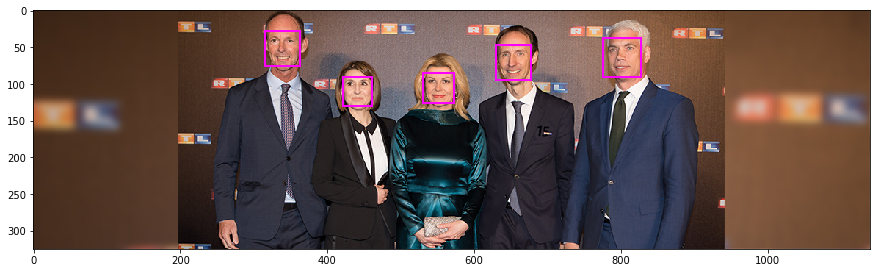

In [337]:
##  Set image_path to the local path of an image that you want to analyze.
image_path = "/Users/doma022/Desktop/AI_Workshop/T_Rabe2.jpg"



# Send request to the CV API
analysis = SendRequestLocal(image_path,
                            params = {'visualFeatures': 'Categories, Description, Faces',
                                      'details': 'Celebrities'})



## Print the image and the API response

fig = PlotImageLocal(image_path)

## Sort faces from left to right
sorted_faces = sorted(analysis["faces"], key=lambda k: k['faceRectangle']["left"]) 

## Print rectangles and descriptions
PrintRectFace(sorted_faces, fig)

#print(analysis)
#print(analysis["description"]["captions"])

print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


## CELEBRITY DETECTION

{'name': 'Thomas Rabe', 'confidence': 0.9986841082572937, 'faceRectangle': {'left': 315, 'top': 28, 'width': 48, 'height': 48}}
{'name': 'Kolinda Grabar-Kitarovic', 'confidence': 0.9993485808372498, 'faceRectangle': {'left': 531, 'top': 85, 'width': 41, 'height': 41}}
CAPTION:
Thomas rabe, kolinda grabar-kitarovic posing for a photo


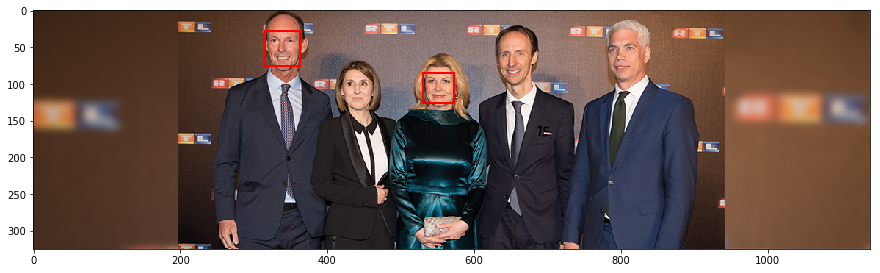

In [334]:
## Print the image and the API response

fig = PlotImageLocal(image_path)

## Sort faces from left to right
sorted_celeb= sorted(analysis["categories"][0]["detail"]["celebrities"],
                     key=lambda k: k['faceRectangle']["left"]) 

## Print rectangles and descriptions
PrintRectFace(sorted_celeb, fig, color='red')


print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


In [321]:
analysis["description"]["tags"]

['person',
 'suit',
 'clothing',
 'photo',
 'standing',
 'man',
 'posing',
 'front',
 'holding',
 'dressed',
 'people',
 'woman',
 'group',
 'wearing',
 'cake',
 'white',
 'room']

## Example #2

FACES:
{'age': 43, 'gender': 'Male', 'faceRectangle': {'left': 911, 'top': 1105, 'width': 242, 'height': 242}}
{'age': 33, 'gender': 'Male', 'faceRectangle': {'left': 1650, 'top': 1307, 'width': 218, 'height': 218}}
{'age': 32, 'gender': 'Female', 'faceRectangle': {'left': 2285, 'top': 1305, 'width': 188, 'height': 188}}
{'age': 54, 'gender': 'Male', 'faceRectangle': {'left': 2816, 'top': 1362, 'width': 195, 'height': 195}}
{'age': 37, 'gender': 'Female', 'faceRectangle': {'left': 3240, 'top': 1260, 'width': 181, 'height': 181}}
{'age': 58, 'gender': 'Male', 'faceRectangle': {'left': 3683, 'top': 1164, 'width': 193, 'height': 193}}
{'age': 37, 'gender': 'Female', 'faceRectangle': {'left': 4229, 'top': 1401, 'width': 173, 'height': 173}}
{'age': 50, 'gender': 'Male', 'faceRectangle': {'left': 4751, 'top': 1234, 'width': 202, 'height': 202}}
CAPTION:
A group of people posing for a photo


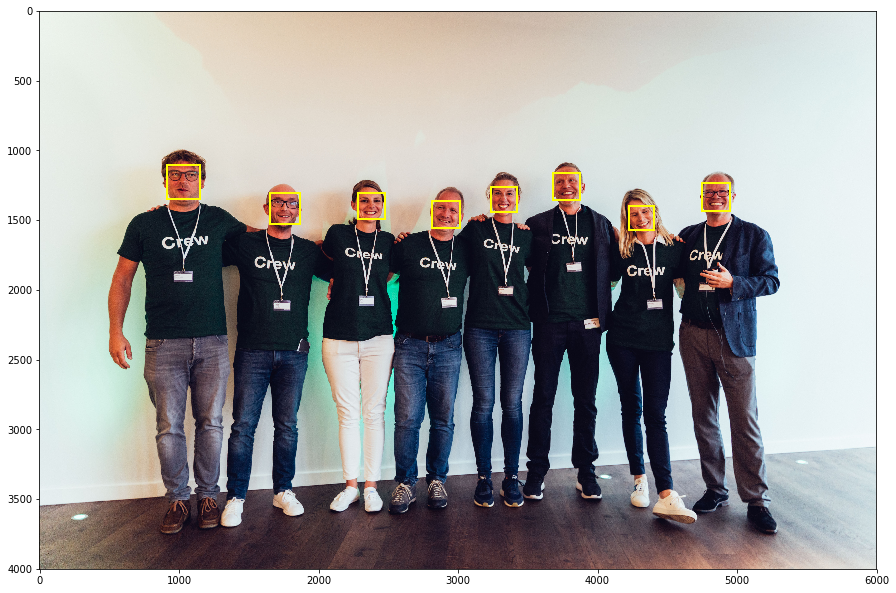

In [335]:
##  Set image_path to the local path of an image that you want to analyze.
image_path = "/Users/doma022/Desktop/AI_Workshop/_DSC7162.jpg"


# Send request to the CV API
analysis = SendRequestLocal(image_path,
                            params = {'visualFeatures': 'Categories, Description, Faces',
                                      'details': 'Celebrities'})



## Print the image and the API response

fig = PlotImageLocal(image_path)


print("FACES:")

## Sort faces from left to right
sorted_faces = sorted(analysis["faces"], key=lambda k: k['faceRectangle']["left"]) 

## Print rectangles and descriptions
PrintRectFace(sorted_faces, fig, color="yellow")


print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


In [323]:
analysis["description"]["tags"]

['person',
 'posing',
 'standing',
 'photo',
 'man',
 'group',
 'wearing',
 'holding',
 'front',
 'people',
 'young',
 'lined',
 'bunch',
 'skiing',
 'woman',
 'team',
 'room',
 'black',
 'table',
 'court']

# OBJECTS - remote

## Example #3

OBJECTS:
{'rectangle': {'x': 0, 'y': 5135, 'w': 326, 'h': 649}, 'object': 'boat', 'confidence': 0.589, 'parent': {'object': 'Watercraft', 'confidence': 0.589, 'parent': {'object': 'Vehicle', 'confidence': 0.591}}}
{'rectangle': {'x': 765, 'y': 4933, 'w': 439, 'h': 493}, 'object': 'boat', 'confidence': 0.615, 'parent': {'object': 'Watercraft', 'confidence': 0.615, 'parent': {'object': 'Vehicle', 'confidence': 0.616}}}
{'rectangle': {'x': 1257, 'y': 4825, 'w': 639, 'h': 542}, 'object': 'boat', 'confidence': 0.663, 'parent': {'object': 'Watercraft', 'confidence': 0.663, 'parent': {'object': 'Vehicle', 'confidence': 0.664}}}
{'rectangle': {'x': 1726, 'y': 4758, 'w': 470, 'h': 377}, 'object': 'boat', 'confidence': 0.503, 'parent': {'object': 'Watercraft', 'confidence': 0.503, 'parent': {'object': 'Vehicle', 'confidence': 0.503}}}
{'rectangle': {'x': 1987, 'y': 5096, 'w': 1498, 'h': 850}, 'object': 'boat', 'confidence': 0.535, 'parent': {'object': 'Watercraft', 'confidence': 0.539, 'parent':

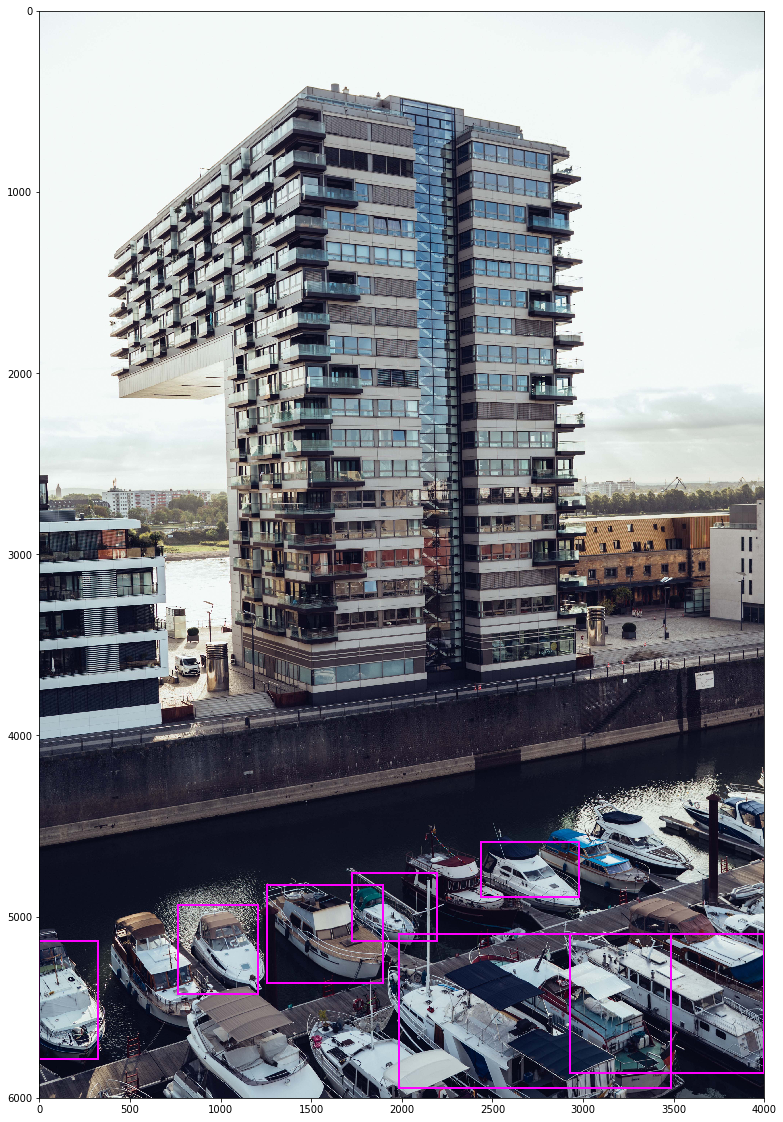

In [324]:
# Cologne
image_path = "/Users/doma022/Desktop/AI_Workshop/_DSC6786.jpg"

# Send request to the CV API
analysis = SendRequestLocal(image_path,
                            params = {'visualFeatures': 'Categories, Description, Objects'})


## Print the image and the API response

fig = PlotImageLocal(image_path)


print("OBJECTS:")
## Sort faces from left to right
sorted_obj = sorted(analysis["objects"], key=lambda k: k['rectangle']["x"]) 

## Print rectangles and descriptions
PrintRectObject(sorted_obj, fig)



print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


In [325]:
analysis["description"]["tags"]

['outdoor',
 'building',
 'boat',
 'large',
 'water',
 'sitting',
 'ship',
 'train',
 'harbor',
 'filled',
 'city',
 'table',
 'covered',
 'bridge',
 'tower',
 'white',
 'track',
 'parked',
 'river',
 'docked',
 'man']

## Example #4

OBJECTS:
{'rectangle': {'x': 1, 'y': 136, 'w': 499, 'h': 580}, 'object': 'person', 'confidence': 0.839}
{'rectangle': {'x': 420, 'y': 265, 'w': 116, 'h': 145}, 'object': 'person', 'confidence': 0.685}
{'rectangle': {'x': 691, 'y': 76, 'w': 298, 'h': 435}, 'object': 'penguin', 'confidence': 0.769, 'parent': {'object': 'bird', 'confidence': 0.773, 'parent': {'object': 'animal', 'confidence': 0.9}}}
CAPTION:
A cat sitting on a table


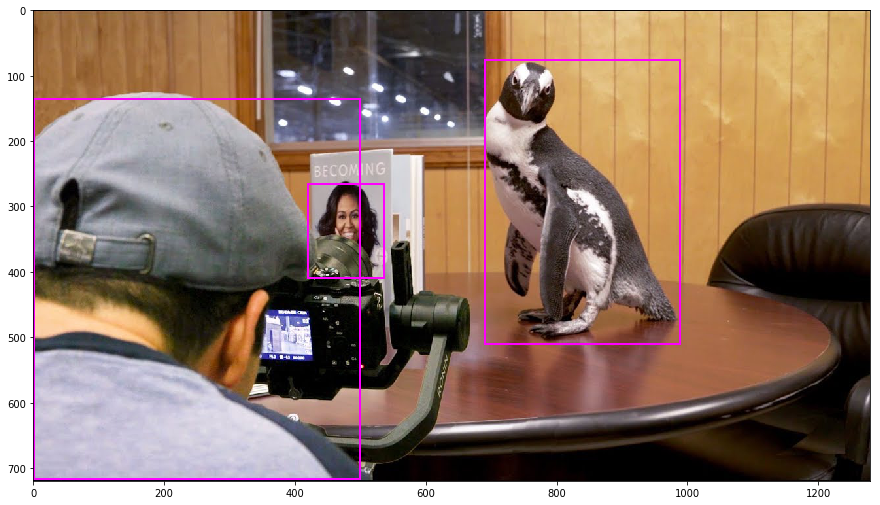

In [327]:
# PRH
image_path = "https://i.ytimg.com/vi/T3kXO_SzeTQ/maxresdefault.jpg"


# Send request to the CV API
analysis = SendRequestUrl(image_path,
                          params = {'visualFeatures': 'Categories, Description, Objects, Faces',
                                    'details': 'Celebrities'})


## Print the image and the API response

fig = PlotImageUrl(image_path)



print("OBJECTS:")

## Sort faces from left to right
sorted_obj = sorted(analysis["objects"], key=lambda k: k['rectangle']["x"]) 

## Print rectangles and descriptions
PrintRectObject(sorted_obj, fig)



print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


In [328]:
analysis

{'categories': [{'name': 'others_', 'score': 0.15234375},
  {'name': 'outdoor_', 'score': 0.00390625, 'detail': {'landmarks': []}}],
 'description': {'tags': ['indoor',
   'cat',
   'table',
   'person',
   'sitting',
   'dog',
   'chair',
   'looking',
   'black',
   'front',
   'watching',
   'standing',
   'living',
   'kitchen',
   'room',
   'man',
   'desk',
   'brown',
   'perched',
   'television',
   'computer',
   'keyboard',
   'holding',
   'woman',
   'white',
   'playing'],
  'captions': [{'text': 'a cat sitting on a table',
    'confidence': 0.8807215440393156}]},
 'faces': [{'age': 44,
   'gender': 'Female',
   'faceRectangle': {'left': 458, 'top': 302, 'width': 50, 'height': 50}}],
 'objects': [{'rectangle': {'x': 420, 'y': 265, 'w': 116, 'h': 145},
   'object': 'person',
   'confidence': 0.685},
  {'rectangle': {'x': 691, 'y': 76, 'w': 298, 'h': 435},
   'object': 'penguin',
   'confidence': 0.769,
   'parent': {'object': 'bird',
    'confidence': 0.773,
    'parent':

# BRANDS

## Example #5

CAPTION:
A screenshot of a cell phone


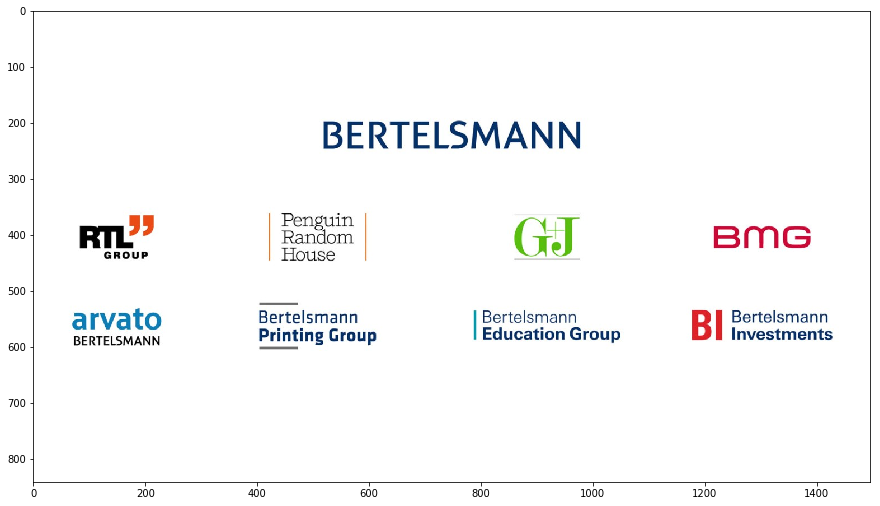

In [282]:
# Brands
image_path = "/Users/doma022/Desktop/AI_Workshop/brands.jpg"

# Send request to the CV API
analysis = SendRequestLocal(image_path,
                            params = {'visualFeatures': 'Categories, Description, Objects, Brands'})


## Print the image and the API response

fig = PlotImageLocal(image_path)

print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


In [285]:
analysis

{'categories': [{'name': 'others_', 'score': 0.01171875},
  {'name': 'text_', 'score': 0.86328125}],
 'description': {'tags': ['clothing', 'footwear'],
  'captions': [{'text': 'a close up of a footwear',
    'confidence': 0.643525268193749}]},
 'objects': [{'rectangle': {'x': 11, 'y': 0, 'w': 589, 'h': 502},
   'object': 'bowling shoe',
   'confidence': 0.572,
   'parent': {'object': 'footwear', 'confidence': 0.63}},
  {'rectangle': {'x': 272, 'y': 15, 'w': 576, 'h': 475},
   'object': 'footwear',
   'confidence': 0.609}],
 'brands': [{'name': 'Reebok',
   'confidence': 0.8,
   'rectangle': {'x': 181, 'y': 186, 'w': 98, 'h': 72}}],
 'requestId': '1fc39085-510c-4eb4-b5a0-fd766f7a0c31',
 'metadata': {'width': 870, 'height': 505, 'format': 'Jpeg'}}

## Example #6

OBJECTS:
{'rectangle': {'x': 11, 'y': 0, 'w': 589, 'h': 502}, 'object': 'bowling shoe', 'confidence': 0.572, 'parent': {'object': 'footwear', 'confidence': 0.63}}
{'rectangle': {'x': 272, 'y': 15, 'w': 576, 'h': 475}, 'object': 'footwear', 'confidence': 0.609}
BRANDS:
{'name': 'Reebok', 'confidence': 0.8, 'rectangle': {'x': 181, 'y': 186, 'w': 98, 'h': 72}}
CAPTION:
A close up of a footwear


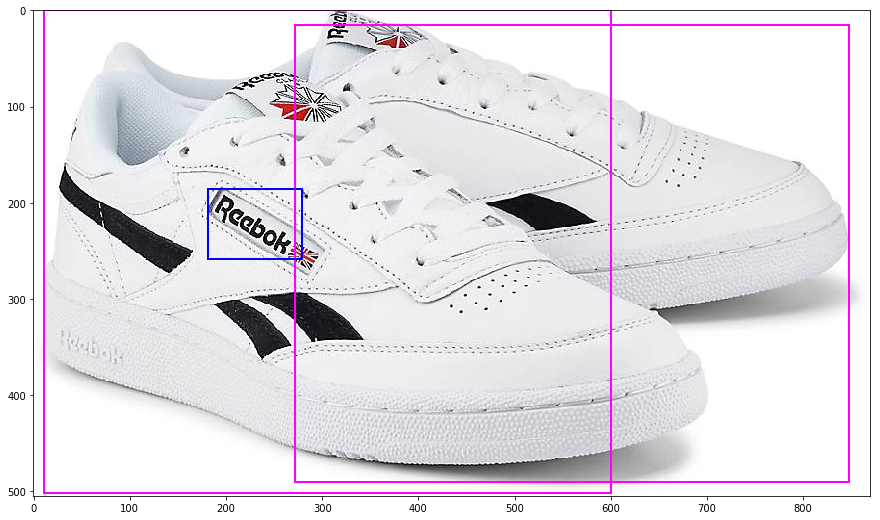

In [329]:
# Cologne
image_path = "/Users/doma022/Desktop/AI_Workshop/reebook.jpg"

# Send request to the CV API
analysis = SendRequestLocal(image_path,
                            params = {'visualFeatures': 'Categories, Description, Objects, Brands'})


## Print the image and the API response

fig = PlotImageLocal(image_path)



print("OBJECTS:")
## Sort faces from left to right
sorted_obj = sorted(analysis["objects"], key=lambda k: k['rectangle']["x"]) 

## Print rectangles and descriptions
PrintRectObject(sorted_obj, fig)


print("======")
print("BRANDS:")
## Sort faces from left to right
sorted_brands = sorted(analysis["brands"], key=lambda k: k['rectangle']["x"]) 

## Print rectangles and descriptions
PrintRectObject(sorted_brands, fig, color="blue")


#print(analysis)
#print(analysis["description"]["captions"])

print("======")
print("CAPTION:")
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)


# OCR (optical character recognition)

## Example #7

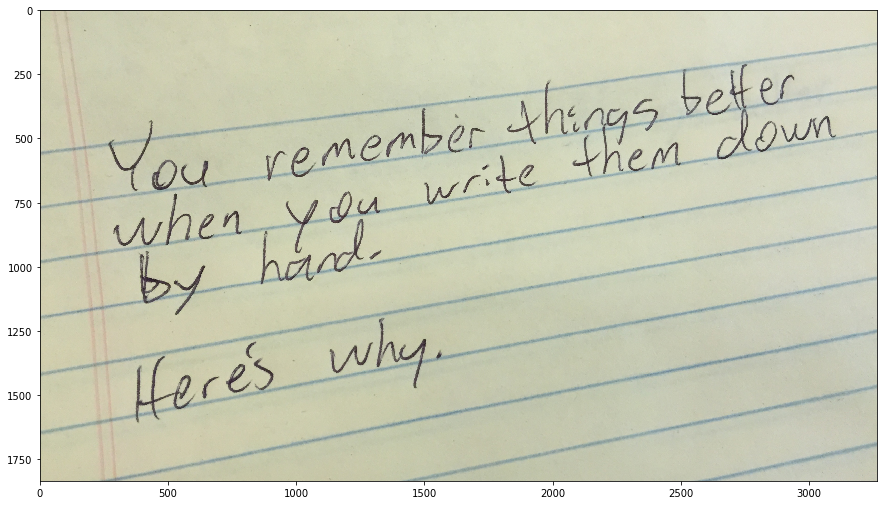

In [330]:
#image_path = "/Users/doma022/Desktop/AI_Workshop/OCR.jpg"
image_path = "https://media.npr.org/assets/img/2016/04/17/handwritten-note_wide-941ca37f3638dca912c8b9efda05ee9fefbf3147.jpg"

# Display the image and overlay it with the extracted text.
fig = PlotImageUrl(image_path)

{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 350.52, 'width': 3263, 'height': 1835, 'unit': 'pixel', 'lines': [{'boundingBox': [238, 490, 2934, 135, 2968, 393, 272, 748], 'text': 'You remember things better', 'words': [{'boundingBox': [284, 487, 697, 466, 717, 685, 302, 727], 'text': 'You'}, {'boundingBox': [855, 454, 1803, 353, 1828, 545, 876, 667], 'text': 'remember'}, {'boundingBox': [1850, 346, 2446, 249, 2474, 444, 1875, 538], 'text': 'things'}, {'boundingBox': [2493, 241, 2929, 154, 2960, 360, 2521, 436], 'text': 'better', 'confidence': 'Low'}]}, {'boundingBox': [264, 791, 3091, 340, 3120, 522, 293, 973], 'text': 'when you write them down', 'words': [{'boundingBox': [286, 789, 802, 726, 819, 881, 299, 946], 'text': 'when'}, {'boundingBox': [967, 704, 1327, 654, 1347, 806, 985, 858], 'text': 'you'}, {'boundingBox': [1491, 630, 1963, 554, 1988, 704, 1513, 782], 'text': 'write'}, {'boundingBox': [2107, 529, 2464, 465, 2493, 615, 2132, 680], 'tex

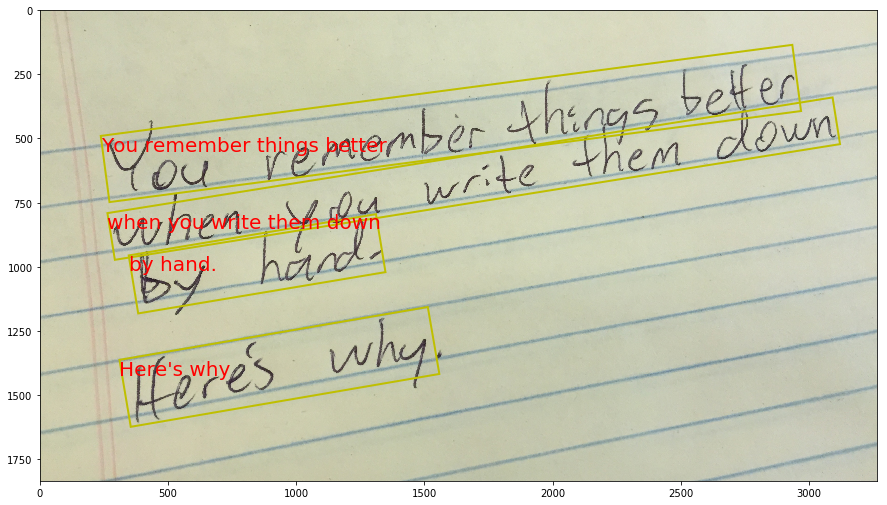

In [319]:
image_path = "https://media.npr.org/assets/img/2016/04/17/handwritten-note_wide-941ca37f3638dca912c8b9efda05ee9fefbf3147.jpg"


# Send request to the CV API
analysis = SendRequestOCRUrl(image_path)


# Display the image and overlay it with the extracted text.
fig = PlotImageUrl(image_path)



polygons = []
if ("recognitionResults" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["recognitionResults"][0]["lines"]]

    
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    fig.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top", color='red')
